# Use PMFA to analyze the E. coli flux data

MIT License

Copyright (c) 2019 Elad Noor

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [1]:
import sys
from os.path import expanduser

import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import seed
from scipy.linalg import norm
from escher import Builder
import seaborn as sns
from cobra.test import create_test_model
sys.path.append(expanduser("~/git/efm-ecoli/pmfa"))
from pmfa import PMF
from sklearn.decomposition import PCA

BEST_LAMBDA = 0.3

In [2]:
INPUT_FNAME = "src/flux_components/data/meta_analysis.xls"

reactions_sheet = pd.read_excel(INPUT_FNAME, sheet_name="reactions", header=0,
                                index_col=0)
S = reactions_sheet.iloc[0:46, 6:].applymap(float).T
S.fillna(0.0, inplace=True)

L = reactions_sheet.iloc[0:46, 4] / 100.0
U = reactions_sheet.iloc[0:46, 5] / 100.0

fluxes_sheet = pd.read_excel(INPUT_FNAME, sheet_name="fluxes", skiprows=1,
                             header=0, index_col=None)
growth_rate = fluxes_sheet["growth rate [h-1]"].apply(float)
flux_df = fluxes_sheet.loc[~np.isnan(growth_rate), S.columns].applymap(float).T
flux_df.fillna(0.0, inplace=True)

# fill in the biomass reaction (based on the growth rate and biomass model)
# TODO: implement this properly, now we only use the default model (Schuetz)
biomass_df = pd.read_excel(INPUT_FNAME, sheet_name="e_coli_schuetz_biomass",
                           header=0, index_col=None)
S["BIOMASS"] = -biomass_df.iloc[:, 2:].T
S["BIOMASS"].fillna(0.0, inplace=True)
L["BIOMASS"] = 0.0
U["BIOMASS"] = 10.0

# calculate the relative fluxes
inv_glc_uptake = 1.0 / flux_df.iloc[1:9, :].sum(axis=0)
rel_flux_df = flux_df.multiply(inv_glc_uptake)

In [3]:
n_components = 3

seed(2019)  # to facilitate comparison between different runs
pmf = PMF(rel_flux_df.values, S.values, L, U, order=2)
W, _ = pmf.solve(BEST_LAMBDA, n_components=n_components)
explained_var = pmf.variance_explained(W)
residuals_l1 = pmf.residuals(W, 1)
residuals_l2 = pmf.residuals(W, 2)
for j in range(n_components):
    cum_exp_var = explained_var[:j+1].sum()
    print(f"component #{j+1}, "
          f"cumulative explained var = {cum_exp_var:.4g}, "
          f"residual l1 = {residuals_l1[j]:.4g}, "
          f"residual l2 = {residuals_l2[j]:.4g}, "
          f"||W||_l1 = {norm(W[:, j], ord=1):.4g}, "
          f"||W||_l2 = {norm(W[:, j], ord=2):.4g}")

component #1, cumulative explained var = 0.4905, residual l1 = 3.05, residual l2 = 1.138, ||W||_l1 = 3.049, ||W||_l2 = 1
component #2, cumulative explained var = 0.6022, residual l1 = 0.8506, residual l2 = 0.2139, ||W||_l1 = 3.345, ||W||_l2 = 1
component #3, cumulative explained var = 0.6201, residual l1 = 0.9471, residual l2 = 0.2797, ||W||_l1 = 3.422, ||W||_l2 = 1


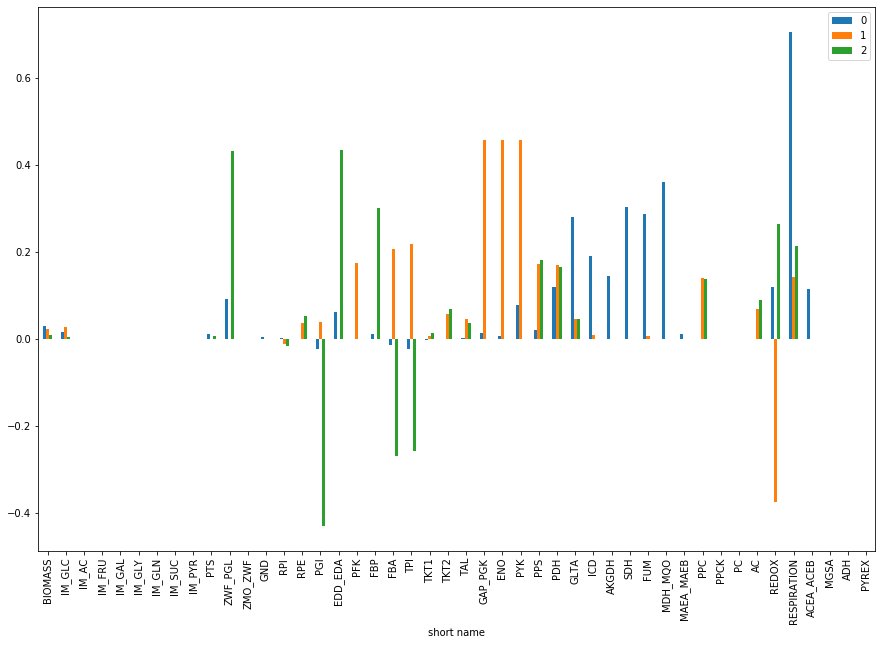

In [4]:
pmf_components = pd.DataFrame(data=W, index=S.columns)
pmf_components.plot.bar(figsize=(15, 10));

In [5]:
sys.path.append(expanduser("~/git/flux-components/src"))
from flux_components.flux_sampler import FluxSampler
from matplotlib.colors import rgb2hex

fsampler = FluxSampler()

for i in range(n_components):
    builder = fsampler.display_in_escher(pmf_components[i], map_name="iJO1366.Central metabolism", max_flux=0.3)
    display(builder)

Fragments already downloaded


Exporting file 2 of 2 [00:00]: compounds.sqlite


Fragments already downloaded


Builder(reaction_data={'ACALD': 0.0, 'ACONTa': 0.27940234081712334, 'ACONTb': 0.27940234081712334, 'ACS': 0.0,…

Builder(reaction_data={'ACALD': 0.0, 'ACONTa': 0.04671333267956594, 'ACONTb': 0.04671333267956594, 'ACS': 0.06…

Builder(reaction_data={'ACALD': 0.0, 'ACONTa': 0.045663567876759584, 'ACONTb': 0.045663567876759584, 'ACS': 0.…

# Compare the PMFA results to PCA

component #1, cumulative explained var = 0.5323, residual l1 = 4.473, residual l2 = 2.33, ||W||_l1 = 2.831, ||W||_l2 = 1
component #2, cumulative explained var = 0.6957, residual l1 = 3.763, residual l2 = 1.612, ||W||_l1 = 4.749, ||W||_l2 = 1
component #3, cumulative explained var = 0.8374, residual l1 = 3.895, residual l2 = 1.987, ||W||_l1 = 4.494, ||W||_l2 = 1


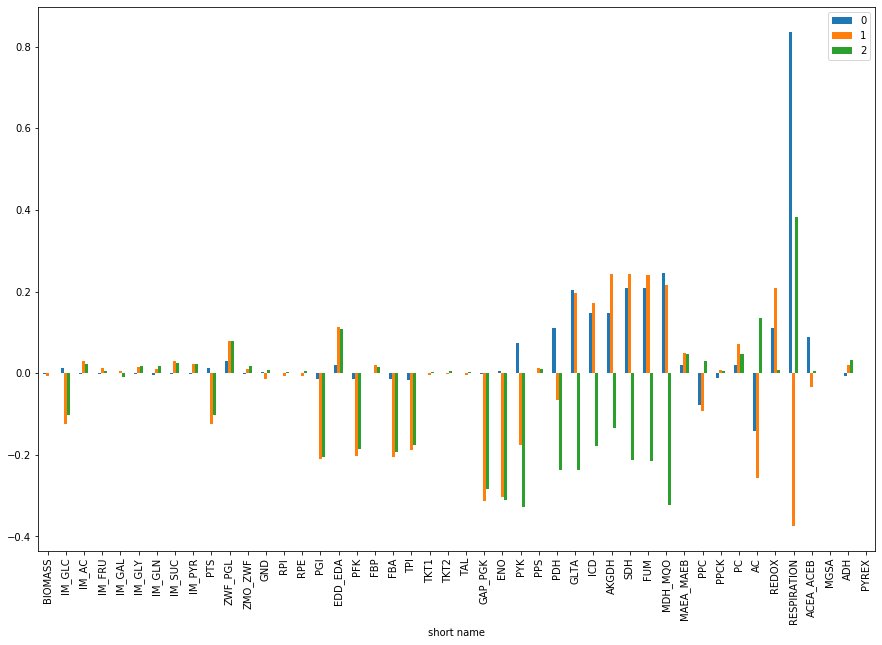

In [6]:
n_components = 3

decomposer = PCA(n_components)
W = decomposer.fit(rel_flux_df.T.values).components_.T

explained_var = pmf.variance_explained(W)
residuals_l1 = pmf.residuals(W, 1)
residuals_l2 = pmf.residuals(W, 2)
for j in range(n_components):
    cum_exp_var = explained_var[:j+1].sum()
    print(f"component #{j+1}, "
          f"cumulative explained var = {cum_exp_var:.4g}, "
          f"residual l1 = {residuals_l1[j]:.4g}, "
          f"residual l2 = {residuals_l2[j]:.4g}, "
          f"||W||_l1 = {norm(W[:, j], ord=1):.4g}, "
          f"||W||_l2 = {norm(W[:, j], ord=2):.4g}")

pca_components = pd.DataFrame(data=W, index=S.columns)
pca_components.plot.bar(figsize=(15, 10));

In [7]:
for i in range(n_components):
    builder = fsampler.display_in_escher(pca_components[i])
    display(builder)

Builder(reaction_data={'ACALD': -0.006337960390148323, 'ACONTa': 0.2039699876043672, 'ACONTb': 0.2039699876043…

Builder(reaction_data={'ACALD': 0.02044328253881278, 'ACONTa': 0.19635636446729082, 'ACONTb': 0.19635636446729…

Builder(reaction_data={'ACALD': 0.03343524909323392, 'ACONTa': -0.23848729994240347, 'ACONTb': -0.238487299942…